In [1]:
from IPython.display import IFrame, Image, display
from py_utils.notebook_utils import get_code_toggle
get_code_toggle()

<center><h1>Cancer Treatment Effectiveness Prediction Project</h1></center>

<hr>
# Contents

- [Motivation](#motivation)
- [Data Overview](#data_overview)
- [Transfer Kernel Model](#transfer_kernel_model)
- [Simulation Results](#simulation_results)
    - [Small-Scale Simulation](#small_scale_simulation)
    - [Large-Scale Simulation](#large_scale_simulation)
- [Application to Breast Cancer](#breast_cancer_app)
    - [Smaller Scale Application](#small_scale_app)
    - [Larger Scale Application](#large_scale_app)
- [Most Promising Results](#most_promising_results)
- [Conclusions](#conclusions)
- [Questions](#questions)

<hr>

<h1><center><a id="motivation">Motivation</a></center></h1>

The purpose of this project is to test the assumptions of a certain model that I'll call a "Transfer Kernel Model" (things like it certainly already exist and that seems to be the most fitting name) in the context of predicting sensitivity to cancer treatments based on patient genomic data.  

The need for this arose from the following situation:

1. I have a small set of breast cancer cell lines (~45) with about 15k gene expression features and I would like to predict the sensitivity of these cell lines to ~200 separate drugs.  These expression features come from the [CCLE](http://software.broadinstitute.org/software/cprg/?q=node/11) and drug sensitivity from [GDSC](http://www.cancerrxgene.org/).
2. I also have a larger set of tumor samples (~400) with 15k gene expression features as well as RPPA (reverse phase protein array) values for ~170 different proteins from the [TCGA](https://cancergenome.nih.gov/) project
3. I would like to be able to use the relationship between the tumor samples and RPPA levels as a way to explain cell line sensitivity to drugs


The reason I want to be able to incorporate the RPPA data is to test the hypothesis that protein levels are, in many causes, a more direct explanation of why a patient will be sensitive to any particular drug.  There are many fewer protein levels of importance than gene expression levels so the hope is that if sensitivity to drugs can be explained in terms of RPPA levels, the conclusions worth drawing about predictability will be much more clear.  

Practically speaking though, some previous experience with trying to predict sensitivity directly showed me that while sensitivity to drugs is at least somewhat predictable, the best models for doing this are unanimously very difficult to interpret (RBF SVM, PCA + OLS, Ridge/Lasso Regression, etc).  For example, a regularized linear model like Lasso will choose single genes from a group of very highly correlated genes as a predictor but in a very unstable way (rarely the same genes in the correlated group are chosen in resampled sets).  Similarly a model like Ridge Regression will simply include all those correlated but predictive genes, ultimately making it very hard to draw any conclusions about what was learned.

It would be great if RPPA data was available in larger quantities for cell lines directly, but that is not the case and in general the most comprehensive public source of this data appears to be the tumor samples in the TCGA dataset.  None of the TCGA samples are related to the cell lines available elsewhere though (they're derived from different patients) so that is another big challenge here.

As a side-note, whether or not gene expression for cell lines are fundamentally different from expression levels for tumor samples is somewhat controversial, but there is a reasonable level of confidence that they are similar enough to be comparable.  For example, a 2015 paper by Laura Heiser and Joe Gray (big names in the space apparently) stated that "A strong correlation was observed for each genomic measurement between cell lines and tumors, suggesting that the cell lines comprising this dataset contained most of the common genomic aberrations found in tumors" [1].


\* Abbreviations Legend:

- **CCLE** -> Cancer Cell Line Encyclopedia
- **TCGA** -> The Cancer Genome Atlas
- **GDSC** -> Genomics of Drug Sensitivity in Cancer

[1] - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4828339/

<hr>

<h1><center><a id="data_overview">Data Overview</a></center></h1>

To make the data I am working with more concrete before jumping into explanations of models and training results, here are examples of what the different features and outcomes look like and how they are defined:

In [2]:
def load_sample(filename):
    import pandas as pd
    import os
    SAMPLE_DIR = '/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/samples'
    return pd.read_pickle(os.path.join(SAMPLE_DIR, filename))

### CCLE and TCGA Gene Expression (ie Features)

These expression levels range from -18 to 30 but average around 0 and correspond to the level of mRNA in a tumor sample vs a normal tissue sample from the same patient (the actual number is typically log base 2 of the ratio of expression in an infected tissue over control tissue).

Here is a sample of a data frame containing this information:

In [3]:
load_sample('genomic_features.pkl')

,GENE,A1BG,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,AADAT
CELL_LINE_ID:MGDS,PRIMARY_SITE:MGDS,,,,,,,,,,
AU565,BREAST,-0.7203,0.2146,1.4553,-0.6623,-0.5925,1.8444,1.6000,-0.0267,-0.5664,-0.6264
BT20,BREAST,-0.7066,-0.5051,0.6345,-0.9157,0.5173,-0.0836,0.8155,-0.4130,0.6665,-1.7076
BT474,BREAST,-1.2665,-0.4155,-0.3491,-0.2819,-0.3083,-0.5347,0.1965,-0.3221,-0.6366,-0.1124
BT483,BREAST,0.6909,-0.2528,-0.1435,0.7511,-0.9741,-0.9885,0.6537,-0.2252,-0.0677,0.2028
BT549,BREAST,1.3433,-0.3780,-0.1978,0.1811,-0.4132,0.5231,-2.0494,-0.5520,0.4526,-1.0863


### TCGA RPPA Levels

These protein array values range from about -7 to 11 and also average around 0.

Sample from data frame containing this information:

In [4]:
load_sample('rppa.pkl')

PROTEIN,ABL1,ACACA,ACVRL1,ADAR,AKT1,AKT2
SAMPLE_ID,,,,,,
TCGA-A1-A0SH-01,0.1414,1.7752,-0.2407,-0.7190,0.7654,0.7654
TCGA-A1-A0SJ-01,-1.0458,0.3505,-0.1300,-0.5828,0.0138,0.0138
TCGA-A1-A0SK-01,-0.3807,-0.9959,-0.6685,0.8784,-0.3473,-0.3473
TCGA-A1-A0SO-01,-0.2390,0.6525,-0.7010,0.9611,1.0870,1.0870
TCGA-A2-A04N-01,0.6021,-1.1306,0.8882,-0.4393,-0.0384,-0.0384


### Drug Sensitivities

These log(IC50) (base e) values from the GDSC project measure the concentration of a drug necessary to inhibit tumor growth by half.  A sensitivity of around -1 or less on the log scale is typically considered to be an "effective" drug since that implies that it takes relatively little of the compound for it to mitigate cancer cell growth while not being present in high enough concentrations to damage or kill other healthy cells (and have nasty side effects).

These values range from -7 to 11 and typically average around 2.5 (meaning that most drugs are NOT very effective).  Values of -1 or less are relatively rare and occur in only ~10% of all measurements taken.

Sample from data frame containing this information:

In [5]:
load_sample('drug_sensitivity.pkl')

,DRUG,17AAG,5FLUOROURACIL,5Z7OXOZEAENOL,681640,AC220,AFATINIB
CELL_LINE_ID:MGDS,PRIMARY_SITE:MGDS,,,,,,
BT20,BREAST,-0.867087,5.330484,1.131463,2.167905,2.516425,3.002986
BT474,BREAST,-3.320525,3.677684,0.913706,3.432221,2.277451,0.222930
BT483,BREAST,0.356745,2.868350,1.831044,3.291616,3.507311,6.779484
CAL120,BREAST,-0.506500,3.580095,0.055861,1.559796,2.801162,3.452226
CAL51,BREAST,-3.708077,3.747422,-0.262070,1.394004,1.760656,3.113380


<hr>

<h1><center><a id="transfer_kernel_model">Transfer Kernel Model</a></center></h1>

The model that will be built and applied in this project attempts to extend the following, more typical modeling scenario:

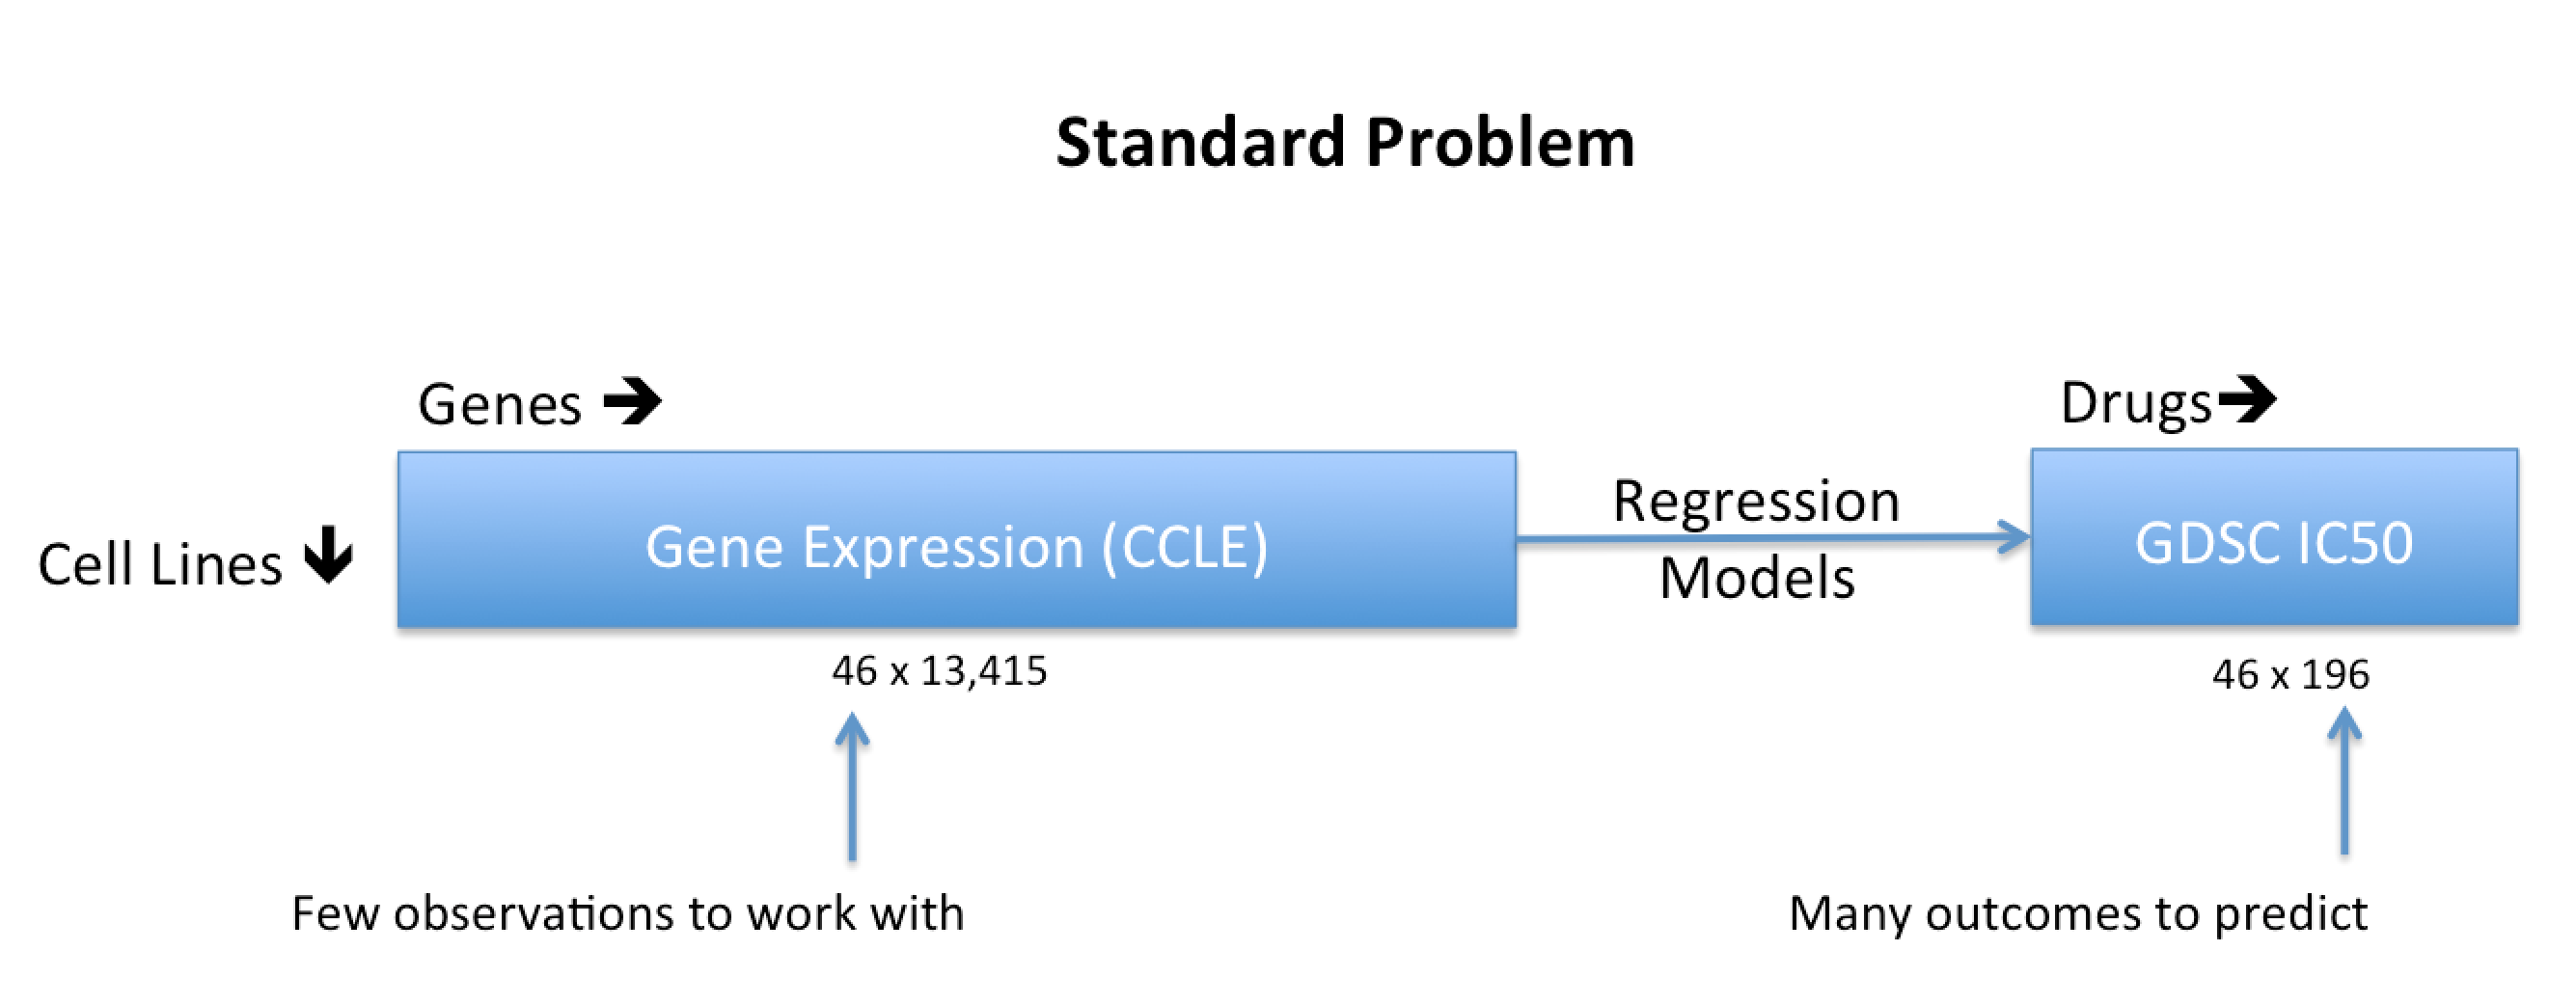

In [6]:
display(Image('docs/images/standard_prob.png', embed=True))

\* Problems like the above are things that I've tried with many variations using different models, completely different data sources than those listed here, different cancer types, etc. and the results are nearly always the same -- some level of predictability is acheivable in many tasks but the results from the models capable of doing that give little useful information on the source of that predictability.

### Modeling Information from Multiple Sources

The purpose of the proposed model below is to solve a similar problem as the above with augmentation from an external dataset:

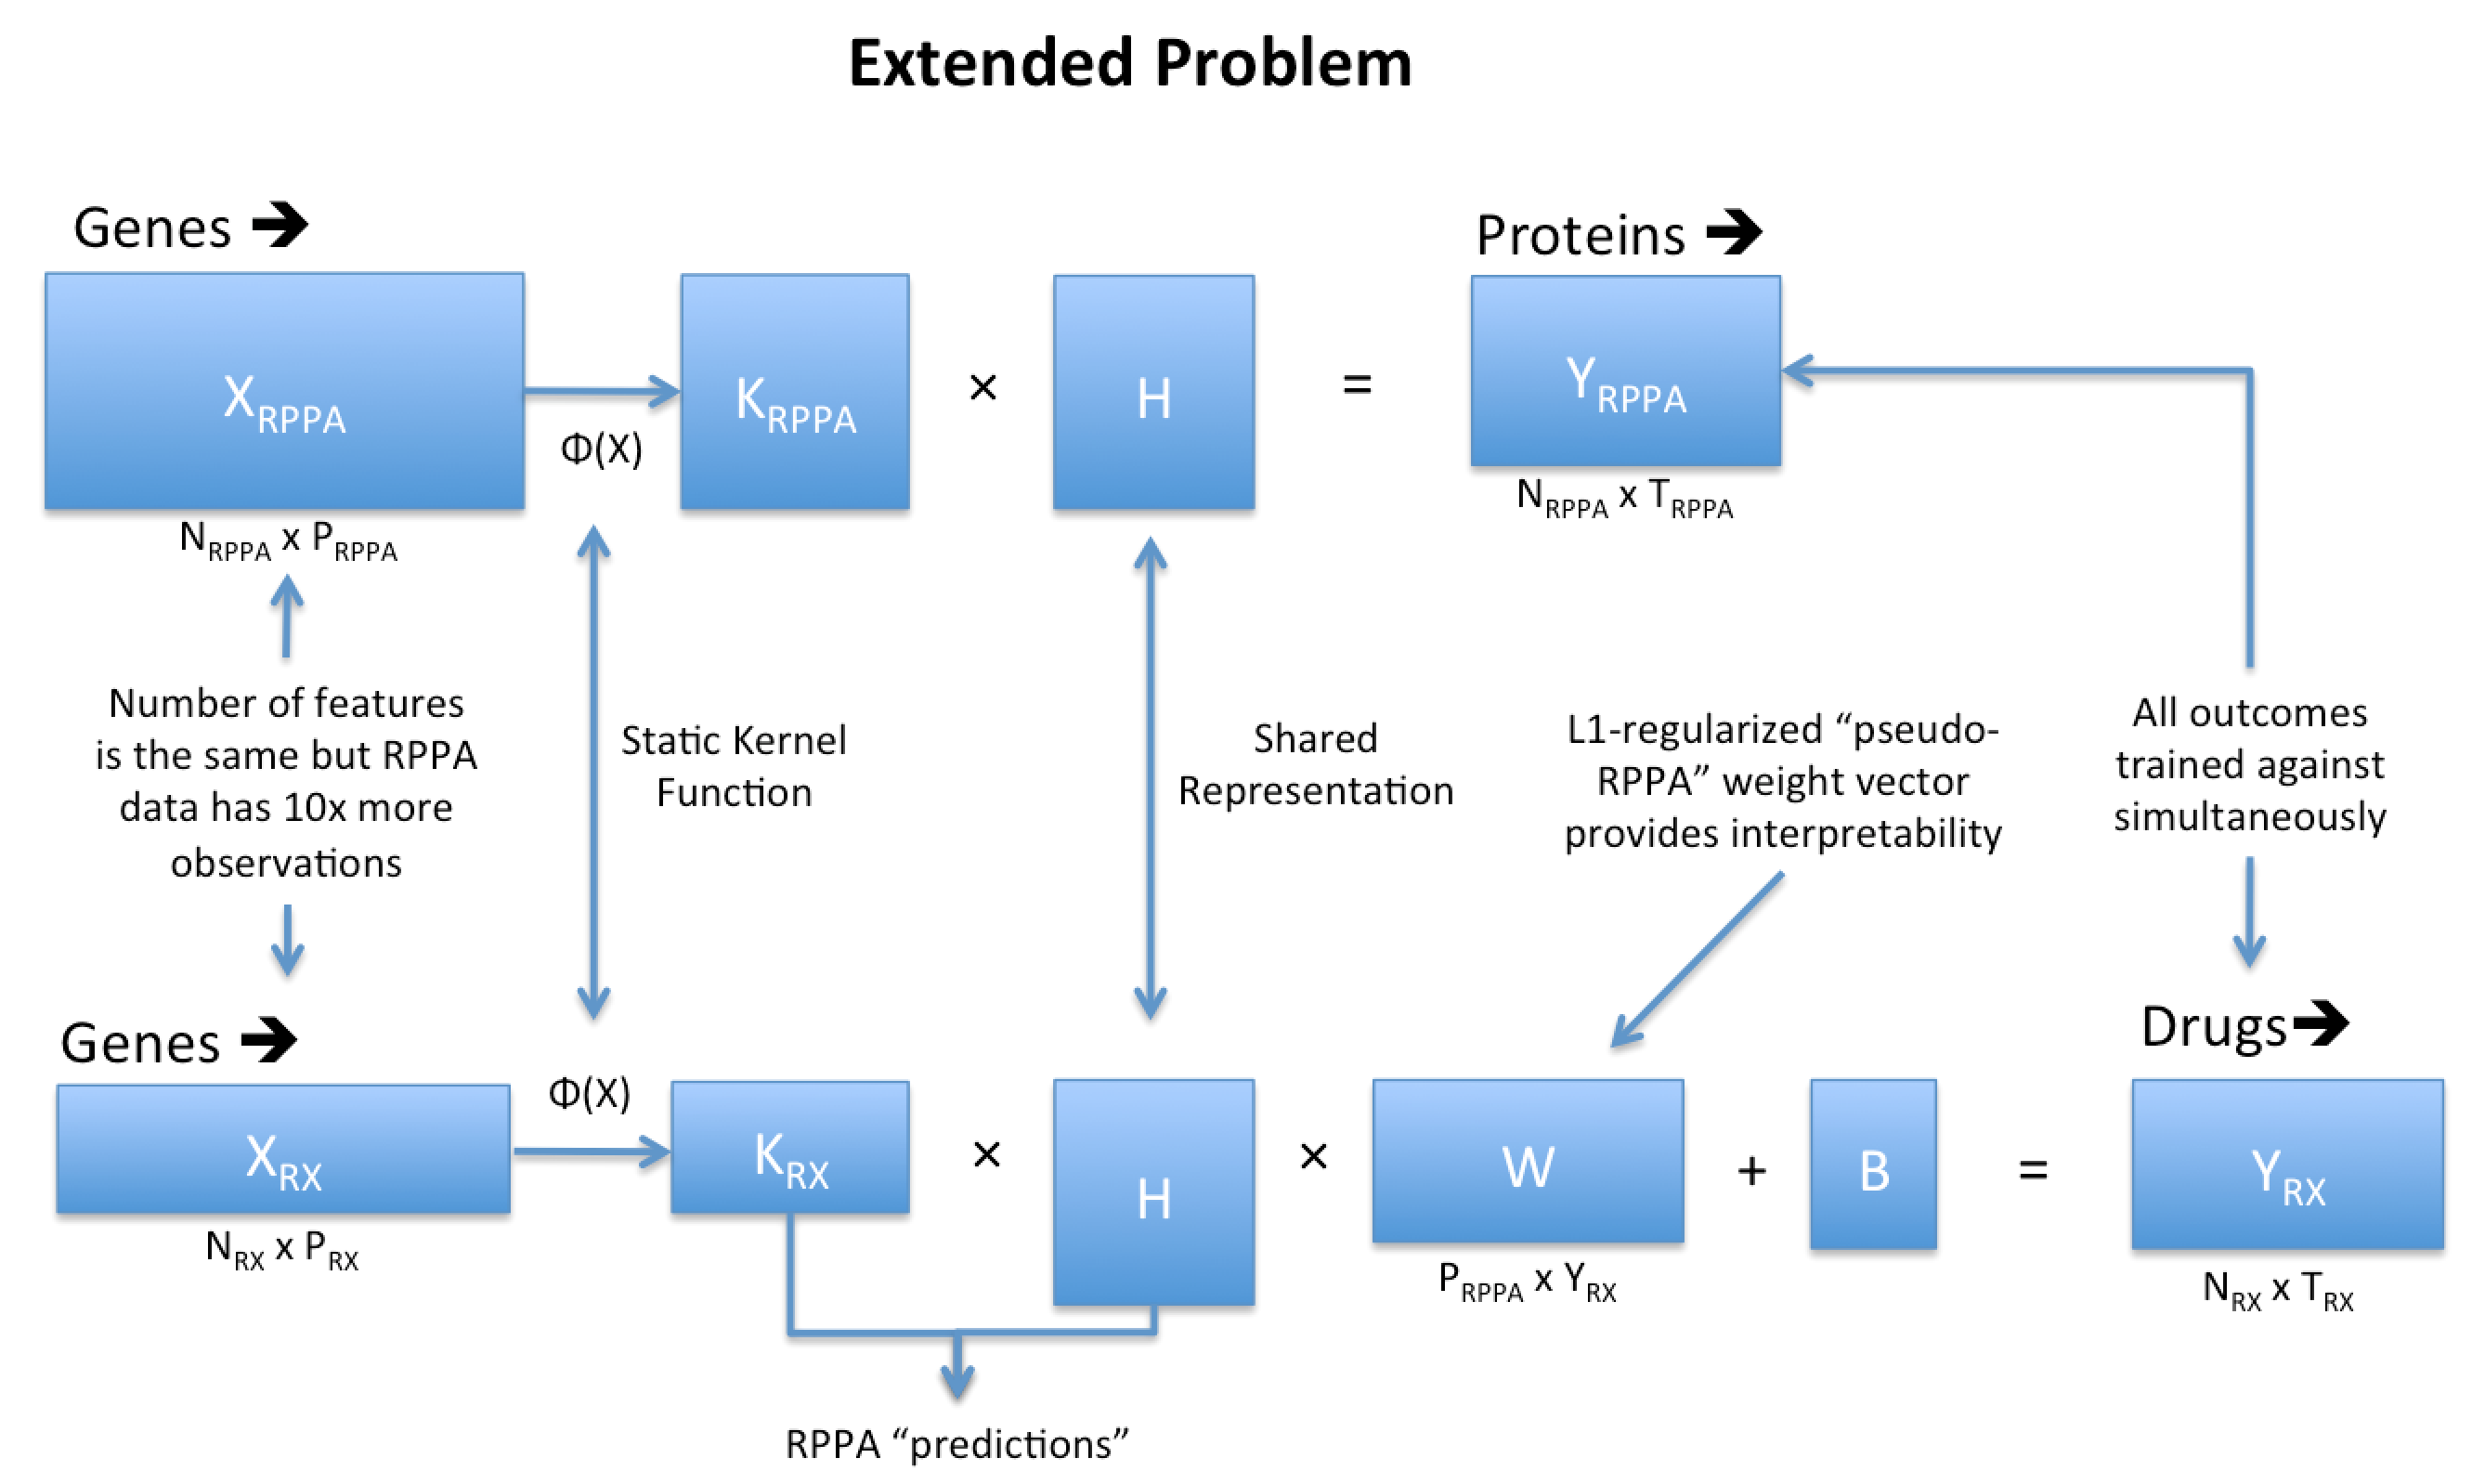

In [7]:
display(Image('docs/images/extended_prob.png', embed=True))

Important notes on the above:

- For my breast-cancer specific problem I will have 46 cell lines ($N_{rx} = 46$).  While this is low, I am optimistic about it being possible based on this paper: [A community effort to assess and improve drug sensitivity prediction algorithms](http://www.nature.com/nbt/journal/v32/n12/full/nbt.2877.html).  This competition involved 44 separate teams trying to predict breast cancer drug sensitivity for only 53 cell lines (and it's more like 30-40 if you look at mostly complete cases per the predictive features), and none of those models involved the use of separate protein arrays as I am attempting to do.
- The winner above used a bayesian, multi-task, multi-kernel model to blend several sources of data and improve predictions through simultaneous training on tasks.  The details of this model can be found [here](https://www.nature.com/nbt/journal/v32/n12/extref/nbt.2877-S1.pdf) (Kernel Method 1).  Several of the implementation details in my model are taken from this approach.

## Model Implementation Details

- The model being trained involves maximum a posteriori estimation of all parameters
- The radial-basis kernel function was used with a gamma parameter ($\gamma$) of $\frac{1}{N_{rows}}$ where gamma is used in the kernel as $e^{-\gamma||x - y||^2}$
- Training consisted of 2500 gradient descent steps 

In [9]:
# Necessary Libraries
import edward     as ed
import tensorflow as tf
import numpy      as np
import pandas     as pd
from edward.models            import Normal, Laplace, PointMass
from sklearn.preprocessing    import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel


def compute_kernel(X, Xs=None, gamma=None):
    return rbf_kernel(X, Y=Xs, gamma=gamma)


class TransferKernelModel(ed_models.BayesianModel):

    def __init__(self, X_rppa, Y_rppa, gamma=None):
        self.initialize()
        self.gamma = gamma
        self.X_rppa = X_rppa
        self.Y_rppa = Y_rppa

    def inference_args(self, data):
        """ Build computational graph for model """
        # Tensor matrices
        lv = {}
        tm = {}

        # Reference the RPPA data given to the model on construction 
        # * The drug sensitivity and genomic data is the only dynamic part of the model,
        #   RPPA reference data is assumed to be static
        dX_rppa, dY_rppa = self.X_rppa, self.Y_rppa
        
        # Extract the genomic features (dX_drug) and the sensitivity values to predict (dY_drug)
        dX_drug, dY_drug = data['X'], data['Y']

        # Apply kernel function to each dataset
        dK_rppa = compute_kernel(dX_rppa, gamma=self.gamma)
        dK_drug = compute_kernel(dX_drug, dX_rppa, gamma=self.gamma)

        # Extract dimensions for easier reference
        N1, P1 = dX_rppa.shape # ~ 46 x 13,415
        N2, P2 = dX_drug.shape # ~ 403 x 13,415
        T1, T2 = dY_rppa.shape[1], dY_drug.shape[1] # ~ 169 x 196
        
        # Register kernel matrices within Tensorflow compuational graph
        K_rppa = tf.constant(dK_rppa, dtype=tf.float32)
        K_drug = tf.constant(dK_drug, dtype=tf.float32)

        # *Note: In most of the following, the distribution (Normal/Laplace) assigned to a matrix is the prior
        # distribution for all values in that matrix and the "PointMass" specification after it corresponds
        # to the parameters of that same matrix that will be used to calculate posterior probabilities (and
        # optimized via gradient descent)
        
        # N1 x T1 kernel weight matrix shared across datasets
        H = Normal(mu=tf.zeros([N1, T1]), sigma=1.*tf.ones([N1, T1]))
        qH = PointMass(params=tf.Variable(tf.random_normal([N1, T1], stddev=.1), name='H'))
        tm['qH'], lv[H] = qH.params, qH

        # T1 x T2 laplace-regularized RPPA coefficient matrix for each drug prediction task
        W = Laplace(loc=tf.zeros([T1, T2]), scale=1.*tf.ones([T1, T2]))
        qW = PointMass(params=tf.Variable(tf.random_normal([T1, T2], stddev=.1), name='W'))
        tm['qW'], lv[W] = qW.params, qW

        # 1 x T2 intercept values for each drug prediction task
        B = Normal(mu=tf.zeros([1, T2]), sigma=1.*tf.ones([1, T2]))
        qB = PointMass(params=tf.Variable(tf.random_normal([1, T2], stddev=.1), name='B'))
        tm['qB'], lv[B] = qB.params, qB

        # N1 x T1 "psuedo-RPPA" predictions, to be used as predictors of drug sensitivity
        YR_mu = tf.matmul(K_rppa, H)
        YR = Normal(mu=YR_mu, sigma=.1 * tf.ones([N1, T1]))

        # N2 x T1 mean matrix for drug sensitivity measurements
        YRD_mu = tf.matmul(K_drug, H)
        YRD = Normal(mu=YRD_mu, sigma=.1 * tf.ones([N2, T1]))

        # N2 x T2 noise model for drug sensitivity (the associated variance is an important regularization param)
        YD_mu = tf.matmul(YRD, W) + B  
        YD = Normal(mu=YD_mu, sigma=1.*tf.ones([N2, T2]))

        # Mean RPPA level predictions, used only to measure training error on these tasks (to make sure they don't overfit)
        qYR = tf.matmul(K_rppa, qH.params)
        qYD = tf.matmul(tf.matmul(K_drug, qH.params), qW.params) + qB.params
        tm['qYD'] = qYD
        
        # Logging calls to Tensorboard to watch training error with each iteration
        mse_rppa = tf.reduce_mean(tf.square(qYR - tf.constant(dY_rppa, dtype=tf.float32)), axis=0)
        tf.summary.scalar('mse_rppa', tf.reduce_mean(mse_rppa))
        mse_drug = tf.reduce_mean(tf.square(qYD - tf.constant(dY_drug, dtype=tf.float32)), axis=0)
        tf.summary.scalar('mse_drug', tf.reduce_mean(mse_drug))

        # Link actual data to their associated sampling distributions (necessary for log prob and gradient calculations)
        targets = lambda d: {YR: dY_rppa, YD: dY_drug}
        
        return targets, lv, tm

    def criticism_args(self, sess, tm):
        """ Construction prediction equation function using the fit parameters """
        H = sess.run(tm['qH'])
        W = sess.run(tm['qW'])
        B = sess.run(tm['qB'])
        dX_rppa = tm['dX_rppa']

        def prediction_function(X):
            """ Get drug sensitivity predictions for new genomic feature matrix X """
            dK_drug = compute_kernel(X, dX_rppa, gamma=self.gamma)
            Y_rppa = np.matmul(dK_drug, H)
            Y_drug = np.matmul(Y_rppa, W) + B
            return Y_drug
        
        return prediction_function



<hr>

<h1><center><a id="simulation_results">Simulation Results</a></center></h1>

To verify that the model will work as intended, two simulations were run.  The first was a smaller scale representation of the real problem and the second was run with nearly the same dimensions of the actual data that will be used.

At the moment, both simulations were constructed as follows:

1. Generate genomic features (ie gene expression) for drug sensitivity prediction: $X_{RX} \sim N(0, 1)$
2. Generate genomic features for RPPA protein level prediction: $X_{RPPA} \sim N(0, 1)$
3. Generate weights equating RPPA genomic features to RPPA outputs: $W_{RPPA} \sim N(0, 1)$
4. Randomly remove all but a small percentage of the above weights, making them 0 (to simulate sparsity)
5. Generate RPPA predictions with a small level of noise as: $Y_{RPPA} \sim N(X_{RPPA} \cdot W_{RPPA}, \epsilon)$
6. Generate RPPA output to drug sensitivity weight matrix: $W_{DRUG} \sim N(0, 1)$
7. Again, randomly remove all but a small percentage of the RPPA -> Drug Sensitivity weights
8. Finally, generate the drug sensitivities with noise as: $Y_{DRUG} \sim N(Y_{RPPA} \cdot W_{DRUG}, \epsilon)$

<h2><a id="small_scale_simulation">Small Scale Simulation</a></h2>

This simulation assumed the following when generating data to train against:

Dimensions: 

- dim($X_{RX}$) = (100, 600)
- dim($X_{RPPA}$) = (500, 600)
- dim($Y_{RX}$) = (100, 8)
- dim($Y_{RPPA}$) = (100, 15)

Weight Selection:

- On average, 50 of the 600 genomic feature weights used to calculate RPPA were non-zero ($I_{RPPA} \sim Bernoulli(50/600)$)
- On average, 3 of the 15 RPPA feature weights used to calculate drug sensitivity were non-zero ($I_{RX} \sim Bernoulli(3/15)$)

### Training

These models were each trained and used to make predictions on 5 CV folds (shuffled, non-repeated CV):

- **Mean Regression** ('_baseline_') - No parameters; this model simply predicts the mean of the outcomes seen in training
- **Lasso Regression** ('_lasso_') - Regularization parameter alpha selected from 25 values in internal 3-fold CV
- **Ridge Regression** ('_ridge_') - Regularization parameter alpha selected from 25 values in internal 3-fold CV
- **RBF Support Vector Regression** ('_svr_') - Complexity parameter C selected from 10 values between 1e-2 and 1e5
- **Transfer Kernel Model** ('_tkm_' or '_mkl_') - There were no internally selected regularization parameters

### Results

Out-of-sample predictions from each model where "DY\*" indicates a particular drug sensitivity task (colors indicate fold number):

<img src='results/simulations/small/pred_sample.png'/>

Predictive performance measured as pearson correlation between predictions and actual values (box and dots span drug tasks):

In [10]:
IFrame(src='results/simulations/small/perf_scores_pearson.html', width=1000, height=500)

### Inference

This figure shows the difference between the RPPA weights inferred by the Transfer Kernel Model and their actual values in the simulation.  The colored boxes show the inferred weight values and the red/blue dots show the actual values.  A "good" inference on a weight is one where, for example, the dot for the actual weight is blue and the inferred weight is positive, i.e. closer to blue/green in color.  In this case, the more non-zero weights were inferred than are actually present, but all of the real weights were selected correctly and with the correct sign:

In [11]:
IFrame(src='results/simulations/small/weight_estimate_tkm.html', width=1000, height=800)

For context on the above, this figure below shows what was learned by the Lasso model.  It would not be expected that these weights are as useful for understanding the outcomes since this model was trained directly on the simulated genetic features rather than the RPPA features, which have a much more direct link to the outcomes:

In [12]:
IFrame(src='results/simulations/small/weight_estimate_lasso.html', width=1000, height=600)

\* Note that the weights for anything other than the transfer kernel model are always going to be associated with the same number of outcomes, but the number of features is much larger which makes interpreting the above difficult.

<h2><a id="large_scale_simulation">Large Scale Simulation</a></h2>


This simulation was an attempt to come close to matching a more realistic version of my problem.  Most of the dimensions are similar:

Dimensions: 

- dim($X_{RX}$) = (46, 600)
- dim($X_{RPPA}$) = (403, 169)
- dim($Y_{RX}$) = (100, 5)
- dim($Y_{RPPA}$) = (100, 15)

Weight Selection:

- On average, 50 of the 600 genomic feature weights used to calculate RPPA were non-zero ($I_{RPPA} \sim Bernoulli(50/600)$)
- On average, 3 of the 15 RPPA feature weights used to calculate drug sensitivity were non-zero ($I_{RX} \sim Bernoulli(3/15)$)


The biggest difference between this and the real problem is the number of genomic features.  It was still just 600 in this simulation but is 13,415 in reality.  The reason 600 was used instead was because using ~13k completely uncorrelated features leads to entirely unpredictive models which is not true in the real version of the problem.  In reality, these features are far more correlated and the actual number of mostly uncorrelated feature groups is much smaller.  Here is an example of the correlation between gene expression features specifically to show what I mean:

<center><h3>CCLE Gene Expression Correlation for Random Sample of 180 Genes</h3></center>
<img src="docs/images/ccle_ge_corr_sample.png">

### Training

(At the moment, this is all the same as in the "small-scale" simulation)

These models were each trained and used to make predictions on 5 CV folds (shuffled, non-repeated CV):

- **Mean Regression** ('_baseline_') - No parameters; this model simply predicts the mean of the outcomes seen in training
- **Lasso Regression** ('_lasso_') - Regularization parameter alpha selected from 25 values in internal 3-fold CV
- **Ridge Regression** ('_ridge_') - Regularization parameter alpha selected from 25 values in internal 3-fold CV
- **RBF Support Vector Regression** ('_svr_') - Complexity parameter C selected from 10 values between 1e-2 and 1e5
- **Transfer Kernel Model** ('_tkm_' or '_mkl_') - There were no internally selected regularization parameters

### Results

Out-of-sample predictions from each model where "DY\*" indicates a particular drug sensitivity task (colors indicate fold number):
<img src='results/simulations/large/pred_sample.png'/>

Predictive performance measured as pearson correlation between predictions and actual values (box and dots span drug tasks):

**NOTE**: Compared to the small-scale simulation, these scores are ~30% lower

In [13]:
IFrame(src='results/simulations/large/perf_scores_pearson.html', width=1000, height=500)

## Inference

This figure shows the difference between the RPPA weights inferred by the Transfer Kernel Model and their actual values in the simulation.  The colored boxes show the inferred weight values and the red/blue dots show the actual values.  A "good" inference on a weight is one where, for example, the dot for the actual weight is blue and the inferred weight is positive, i.e. closer to blue/green in color:

In [14]:
IFrame(src='results/simulations/large/weight_estimate_tkm.html', width=1000, height=800)

Again, for context on the above like in the small-scale simulation, this figure below shows what was learned by the Lasso model and why this many weights are far less helpful in relating what to model learned to anything biological:

In [15]:
IFrame(src='results/simulations/large/weight_estimate_lasso.html', width=1000, height=600)

<hr>

<hr>
<center><h1><a id="breast_cancer_app">Breast Cancer Drug Application</a></h1></center>

All of the resuls below are generated using a set of 13,415 gene expression features for 43 breast cancer cell lines for which sensitivity to any particular cancer drug will be inferred in terms of RPPA protein levels.  This RPPA dataset consists of 13,415 gene expression features as well (and for the same genes specifically) and 169 protein levels for 403 tumor samples.

This is broken into two parts where one part is for a smaller set of 31 drugs and the second part is for a larger set of 196 drugs.  These sets were defined as:

1. **Small Set** (31 drugs) - This set focuses on drugs Stephen and I had already discussed in the past either because he was interested in them specifically or because we knew more about their expected mechanism of action and what genomic factors they should be associated with.  
2. **Large Set** (196 drugs) - This includes the small set but also provides the opportunity to find more novel drug relationships that maybe haven't been studied well yet.

<h3><a id="small_scale_app">Small Scale Application</a></h3>

Before running this model for the entire set of GDSC drugs referenced in [A Landscape of Pharmacogenomic Interactions in Cancer](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4967469/) a subset of those drugs was first run.

This set of 31 drugs included:

- SUNITINIB
- SB590885
- YM201636
- KIN001055
- GSK690693
- YM155
- GEMCITABINE
- JNKINHIBITORVIII
- LY317615
- AZD7762
- XMD132
- CGP60474
- PHA665752
- OLAPARIB
- NG25
- THZ21021
- 681640
- AP24534
- IPA3
- BRYOSTATIN1
- BMS536924
- VX680
- PD0325901
- CISPLATIN
- CHIR99021
- NAVITOCLAX
- NUTLIN3A
- PLX4720
- SB590885
- AG014699
- PD0332991

### Training

For the smaller scale application, each of the following models was trained and used to make predictions on 5 CV folds (shuffled, non-repeated CV):

- **Mean Regression** ('_baseline_') - No parameters; this model simply predicts the mean of the outcomes seen in training
- **Lasso Regression** ('_lasso_') - Regularization parameter alpha in [1., .5, .25, .1, .08, .06] (3-fold internal CV)
- **Ridge Regression** ('_ridge_') - Regularization parameter alpha in 1e^[-3, -2, -1, 0, 1, 2, 3, 4, 5, 6]
- **RBF Support Vector Regression** ('_svr_')** - Complexity parameter C selected from 10 values between 1e0 and 1e5
- **PCA Regression** ('_pcareg_') - 10 PCs selected prior to OLS regression
- **Random Forest** ('_rf_') - Trained with no grid; ie default parameters
- **Transfer Kernel Model** ('_tkm_' or '_mkl_') - There were no internally selected regularization parameters

**NOTE**: All models other than the Transfer Kernel Model are trained on each outcome separately

### Performance

Predictive performance measured as pearson correlation between predictions and actual values (box and dots span drug tasks):

In [16]:
IFrame(src='results/breast_cancer/cv_small/perf_box_pearson.html', width=1000, height=500)

Predictions from resampling for most predictable drugs above, where "most predictable" is defined as p-value for pearson correlation <= .15:

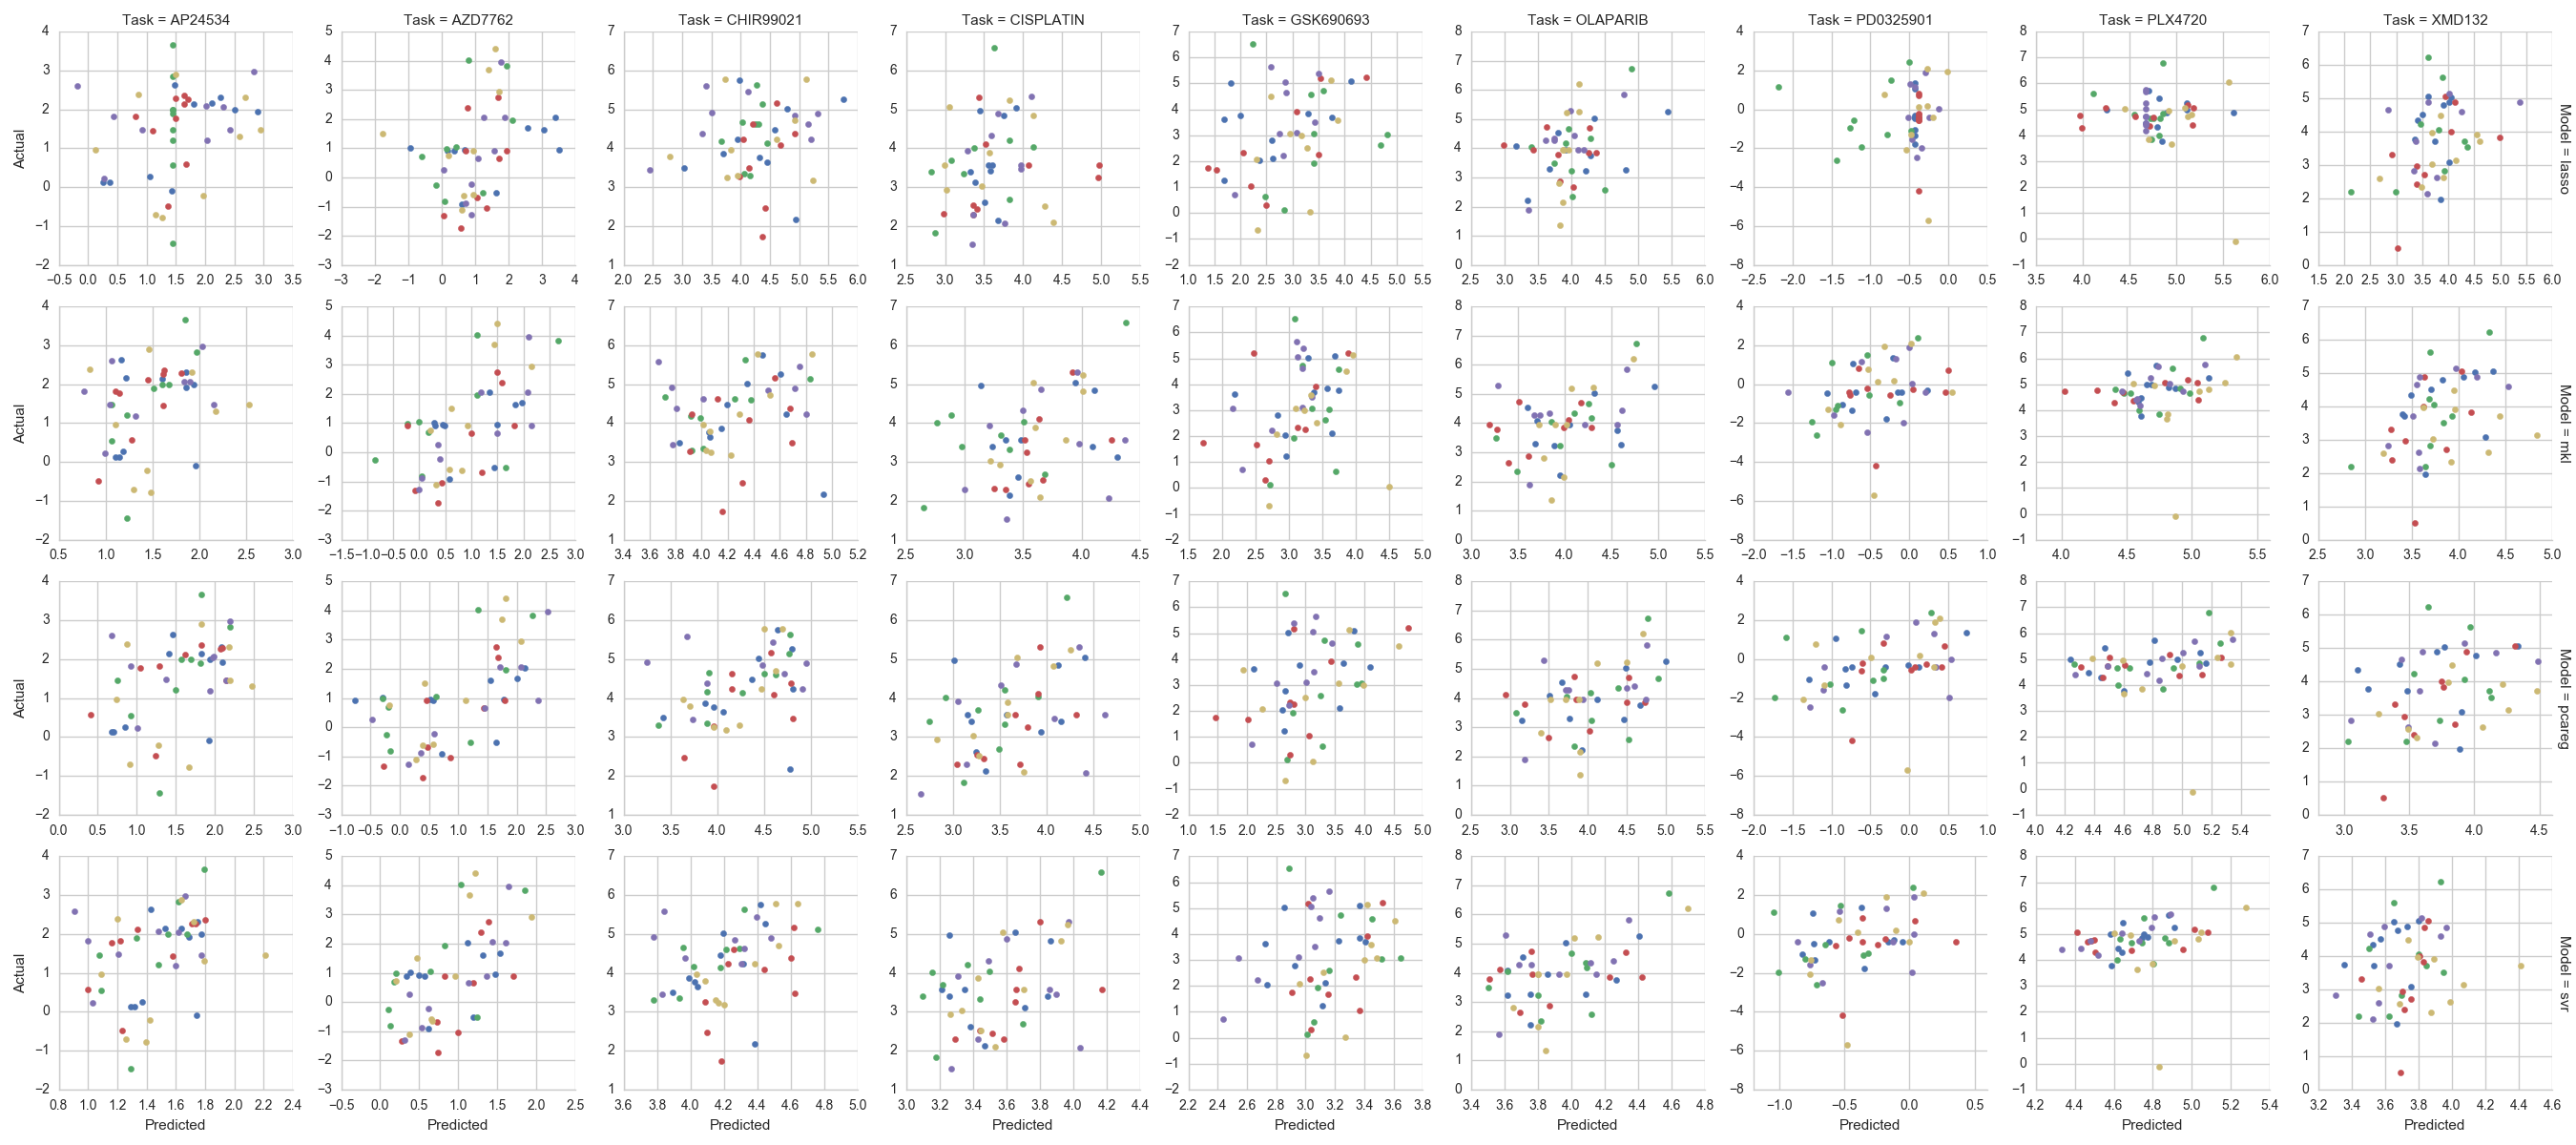

In [17]:
# Predictions on top drugs for small CV:
display(Image('results/breast_cancer/cv_small/pred_top_drugs.png', embed=True))

### Inference

Inferred effects of RPPA levels on drug sensitivity from the Transfer Kernel Model:

In [18]:
IFrame(src='results/breast_cancer/cv_small/rppa_weight_all.html', width=1000, height=600)

Inferred effects of RPPA levels on drug sensitivity from the Transfer Kernel Model, but only for "most predictable" drugs:

In [19]:
IFrame(src='results/breast_cancer/cv_small/rppa_weight_best.html', width=1000, height=500)

<h3><a id="large_scale_app">Large Scale Application</a></h3>

The results here are similar to the section above, though they are for the larger set of 196 drugs (including those above).

### Training

For the larger scale application, each of the following models was trained and used to make predictions on 5 CV folds (shuffled, non-repeated CV):

- **Mean Regression** ('_baseline_') - No parameters; this model simply predicts the mean of the outcomes seen in training
- **Ridge Regression** ('_ridge_') - Regularization parameter alpha in 1e^[-3, -2, -1, 0, 1, 2, 3, 4, 5, 6]
- **PCA Regression** ('_pcareg_') - 10 PCs selected prior to OLS regression
- **Transfer Kernel Model** ('_tkm_' or '_mkl_') - There were no internally selected regularization parameters

**NOTE**: Lasso, Random Forest, and SVR models were left out of this comparison because they each take many hours to train with so many more outcomes.  However, I have a ton of past data on what the results look like for those models (in a single task AND multi task setting) showing that the predtive performances are very similar to the PCA Regression used here.  In other words, I haven't seen anything perform much better than PCA + OLS so far so I think it is a good benchmark to use to make sure the Transfer Kernel Model is at least coming close to matching it.

### Performance

Predictive performance measured as pearson correlation between predictions and actual values (box and dots span drug tasks):

In [20]:
IFrame(src='results/breast_cancer/cv_large/perf_box_pearson.html', width=1000, height=500)

Predictions from resampling for most predictable drugs above, where "most predictable" is defined as p-value for pearson correlation <= .15:

**NOTE:**  This image has to be right-clicked and opened in a separate tab (and then zoomed on) to show anything useful.

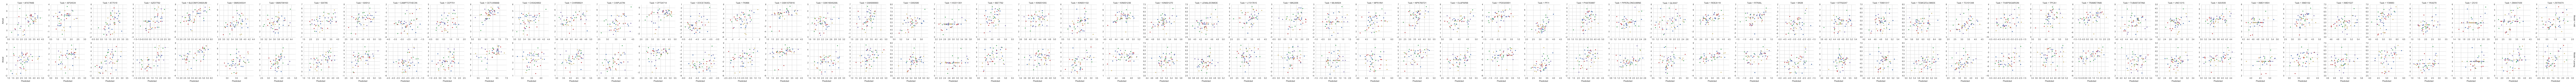

In [21]:
display(Image('results/breast_cancer/cv_large/pred_top_drugs.png', embed=True))

### Inference

Inferred effects of RPPA levels on drug sensitivity from the Transfer Kernel Model:

In [22]:
IFrame(src='results/breast_cancer/cv_large/rppa_weight_all.html', width=1000, height=650)

### Results for Predictable Drug Sensitivities

Of all of the drugs above, only a relatively small subset (61) had "predictable" sensitivity levels, at least in the sense that the p-value associated with the pearson correlation of the out-of-sample predictions was less than or equal to .15.  These drugs are:

- AFATINIB
- AP24534
- AT7519
- AZD7762
- BLEOMYCIN50UM
- BMS345541
- BMS708163
- BX795
- BX912
- CAMPTOTHECIN
- CEP701
- CETUXIMAB
- CH5424802
- CHIR99021
- CISPLATIN
- CP724714
- DOCETAXEL
- FK866
- GSK1070916
- GSK1904529A
- GSK690693
- GW2580
- HG511301
- IBET762
- KIN001055
- KIN001102
- KIN001236
- KIN001270
- LENALIDOMIDE
- LY317615
- MK2206
- MLN4924
- MPS1IN1
- NPK76II721
- OLAPARIB
- PD0325901
- PFI1
- PHA793887
- PIPERLONGUMINE
- QLXII47
- RDEA119
- RTRAIL
- SN38
- STF62247
- T0901317
- TEMOZOLOMIDE
- TG101348
- THAPSIGARGIN
- TPCA1
- TRAMETINIB
- TUBASTATINA
- UNC1215
- XAV939
- XMD1185H
- XMD132
- XMD1527
- Y39983
- YK4279
- ZG10
- ZM447439
- ZSTK474

Inferred effects of RPPA levels on drug sensitivity from the Transfer Kernel Model for the drugs above:

In [23]:
IFrame(src='results/breast_cancer/cv_large/rppa_weight_best.html', width=1000, height=600)

<hr>
<h2><a id="most_promising_results">Most Promising Results</a></h2>

The drugs above can be further filtered down to only those that are even remotely effective as treatments (i.e. having LNIC50 <= -1).  These drugs are:

- TRAMETINIB 
- RTRAIL 
- PD0325901 
- MLN4924 
- AZD7762 
- AFATINIB 
- AT7519 
- CAMPTOTHECIN 
- CEP701 
- FK866
- DOCETAXEL 
- GSK1070916 
- MK2206 
- SN38
- THAPSIGARGIN

Predictions vs actuals for predictable AND sensitive drugs above:

In [24]:
IFrame(src='results/breast_cancer/cv_large/pred_top_drugs_sens_mkl.html', width=1000, height=800)

Inferred RPPA Weights for the drugs above:

**NOTE**: This is a bit understated as just a graphic, but these results are way, way more interpretable than anything I've come up with in the past.  I don't know what biological meaning they might have yet (if any), but I'll be meeting w/ Stephen soon to see if there's anything here.  Previously, anything I've brought to him was too large and noncommital to act on.

In [25]:
IFrame(src='results/breast_cancer/cv_large/rppa_weight_best_and_sensitive.html', width=1000, height=500)

<hr>
<center><h1><a id="conclusions">Conclusions</a></h1></center>

The model applied here showed that it may be possible to explain drug sensitivity "in terms of" protein expression without having a direct link in the data between gene expression, protein expression, and sensitivity.  This could be a helpful technique since, to my knowledge, there is no public dataset that contains all of those things for the same cell lines as well as a large set of drug sensitivities that can be screened against for promising candidates.  While being able to predict sensitivity using much larger sets of genomic features with a practical level of accuracy has been done before, often times it seems that determining the source of that predictability is very difficult (and not having a solid biological explanation for why a drug's sensitivity is predictable seems to be a nonstarter for continued research on that drug).  Accomplishing this with inference expressed in terms of protein expression may make this possible in some of those cases.

Here are a few other conclusions I am walking away from this project with:

- **Feature Selection Methods** - Genomic features are often correlated and correlated groups of those features exhibit relationships with drug sensitivity, which means for linear methods like Lasso, Ridge, and ElasticNet regression that either a small number of those features is chosen from those groups (in an unstable way) or that they're all selected and weighted similarly.  Neither of these behaviors is helpful in determining why a drug sensitivity is predictable.
- **Number of Parameters** - Training a linear model on 13,415 features and 196 drugs requires 2,629,340 individual coefficients and was very time-consuming (6+ hours).  Though the effective number of parameters should be far lower it was still difficult to use anything other than linear methods with analytical solutions like Ridge and PCA+OLS.  By contrast, the Transfer Kernel Model uses only ~100k parameters and trains on all 196 drugs in about a minute.  Part of that difference may be due to the training taking place on a GPU (via Tensorflow) rather than a CPU like the other models.
- **Kernel Methods** - In general the use of kernels in seems to help a lot in building any kind of custom approach to a problem like this where p >> n.  Working with n x n matrices made experimentation much easier/faster so it was great to get some hands-on experience with that difference.

### Future Work

- **Missing Values** - I mean imputed about 10% of the drug sensitivity values I had.  In the past, I had compared the performance of a bunch of different models using different feature scaling and imputation methods (Mean, MICE, Nuclear Norm Minimization, and KNN imputation) but none of those seemed to make any difference so I defaulted here to the simplest method.  In the future though, I would like to be able to include those in the Transfer Kernel Model and either exclude them from the posterior log probability calculation or make them parameters and optimize for them as well.
- **Including More Sources** - I think that I could continue adding more more sources like expression and drug sensitivity for lung cancer (instead of breast cancer) and have all of them share the kernel weight matrix.  I don't know if that would help, but it may be an interesting experiment.
- **Including Different Types of Genomic Data** - Given the method used in the winning solution in [A community effort to assess and improve drug sensitivity prediction algorithms](http://www.nature.com/nbt/journal/v32/n12/full/nbt.2877.html), I think it stands to reason that there could be something useful in including data like Gene Mutations and Gene Methylation (rather than just expression) all with some kind of shared kernel weighting matrix.